In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Harold\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [80]:
df = pd.read_pickle("sanitized_df")
df['compound'] = df.quotation.apply(lambda x: sia.polarity_scores(x)['compound'])

In [81]:
df.head()

,quotation,speaker,qids,date,numOccurrences,urls,phase,quoteLength,quoteWC,compound
quoteID,,,,,,,,,,
2020-02-21-000455,2019 was a landmark year for fiverr as we comp...,Micha Kaufman,[Q26923564],2020-02-21 13:00:00,1,[www.fool.com],E,247,36,0.9117
2020-03-01-005419,councils and communities are passionate about ...,Linda Scott,"[Q19667145, Q469184]",2020-03-01 16:30:28,45,"[cowraguardian.com.au, wauchopegazette.com.au,...",E,198,34,0.1154
2020-03-09-038856,march has the largest amount of acreage burned...,Michael Guy,[Q11107729],2020-03-09 07:37:02,7,"[kvia.com, abc17news.com, localnews8.com, www....",E,89,15,0.2732
2020-02-13-075454,response to the whole range of russian missile...,Jens Stoltenberg,[Q57665],2020-02-13 09:21:05,1,[rferl.org],E,120,17,0.0000
2020-02-10-076321,the national energy and climate plans are how ...,Kadri Simson,[Q13570003],2020-02-10 05:51:51,1,[www.politico.eu],E,211,38,-0.2585


## Entire dataset

<AxesSubplot:xlabel='compound', ylabel='Count'>

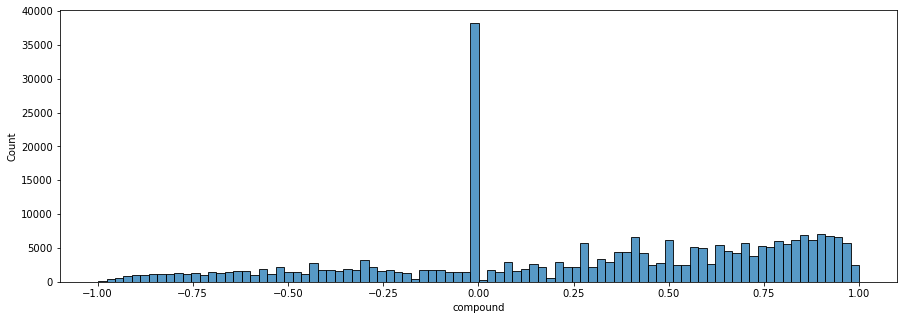

In [82]:
f,x = plt.subplots(1,1,figsize=(15,5))

sns.histplot(data=df, x='compound')

## Yearly observations

In [96]:
df['year'] = df.date.dt.year
df.year = df.year.astype("category")

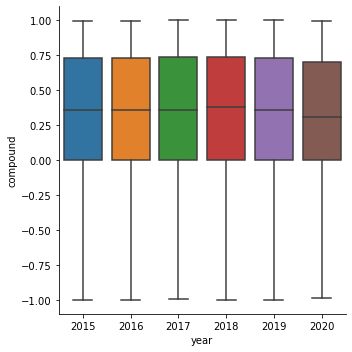

In [97]:
sns.catplot(x="year", y="compound", kind="box", data=df)

Text(0.5, 1.0, 'Average polarity score over the years')

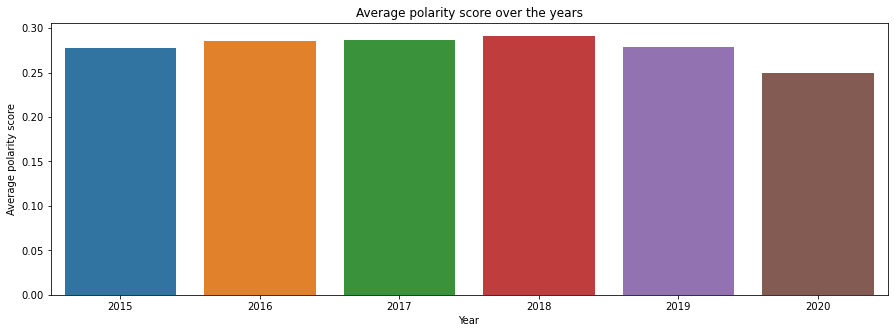

In [98]:
avg_scores = df.compound.groupby(by=df.year).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.barplot(x=df.year.cat.categories, y=avg_scores)

g.set_xlabel("Year")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the years")

## Monthly category

In [99]:
df['month'] = df.date.dt.month
df.month = df.month.astype("category")

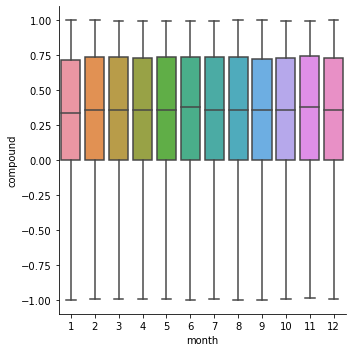

In [100]:
sns.catplot(x="month", y="compound", kind="box", data=df)

Text(0.5, 1.0, 'Average polarity score over the months')

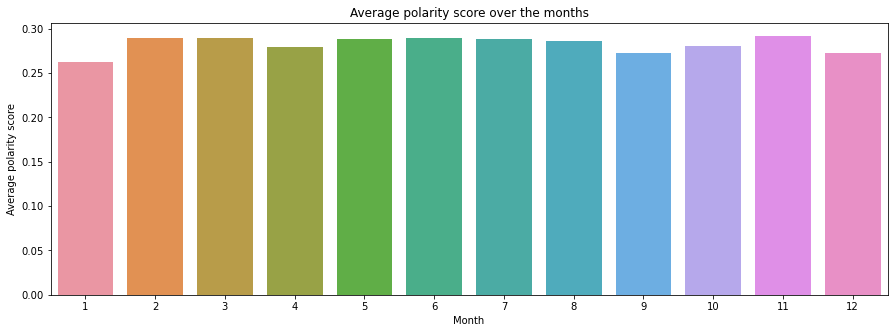

In [108]:
avg_scores = df.compound.groupby(by=df.month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.barplot(x=df.month.cat.categories, y=avg_scores)

g.set_xlabel("Month")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the months")

## Yearly-monthly category

In [101]:
df['year_month'] = df.date.dt.strftime('%y-%m')
df.year_month = df.year_month.astype('category')

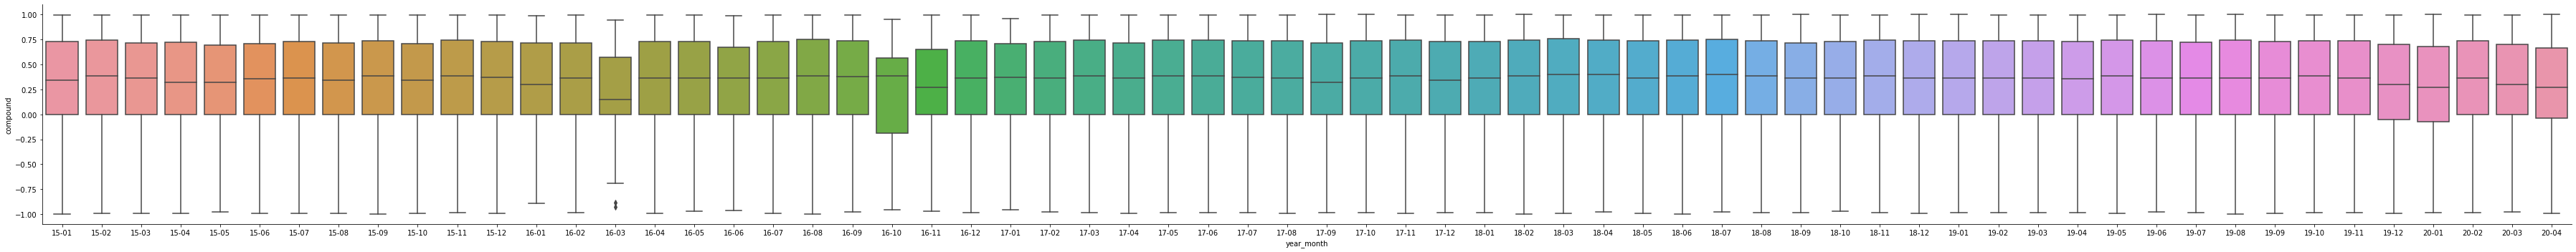

In [102]:
sns.catplot(x="year_month", y="compound", kind="box", data=df,height=5,aspect=10)

(0.0, 0.3226625461641635)

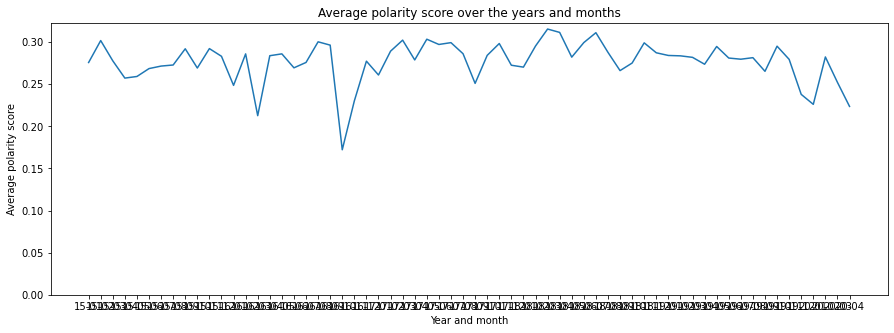

In [112]:
avg_scores = df.compound.groupby(by=df.year_month).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.lineplot(x=df.year_month.cat.categories, y=avg_scores)

g.set_xlabel("Year and month")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the years and months")
g.set_ylim(0)

We notice a dip in November 2016

## Yearly-monthly-daily category

In [109]:
df['year_month_day'] = df.date.dt.strftime('%y-%m-%d')
df.year_month_day = df.year_month_day.astype('category')

In [115]:
len(df.year_month_day.cat.categories)


1891

Text(0.5, 1.0, 'Average polarity score over the years and months and days')

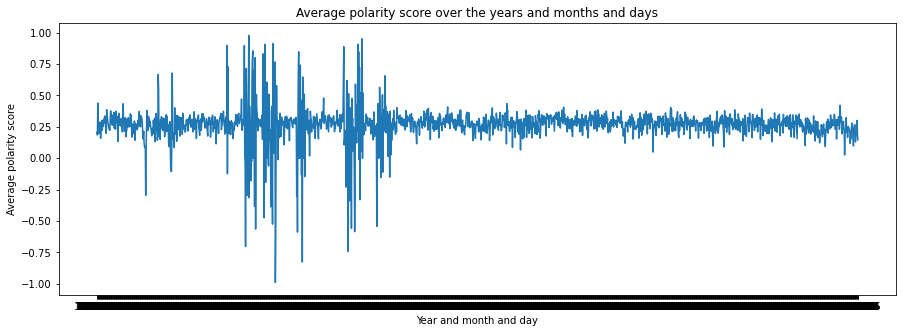

In [117]:
avg_scores = df.compound.groupby(by=df.year_month_day).mean()

f,x = plt.subplots(1,1,figsize=(15,5))

g =sns.lineplot(x=avg_scores.index, y=avg_scores)

g.set_xlabel("Year and month and day")
g.set_ylabel("Average polarity score")
g.set_title("Average polarity score over the years and months and days")
